In [47]:
import json

# Read the JSONL file and inspect the structure of each key
with open('master_resumes_original.jsonl', 'r', encoding='utf-8') as f:
    first_line = f.readline()
    record = json.loads(first_line.strip())
    
    for key in record.keys():
        print(f"\nKey: {key}")
        value = record[key]
        
        # Show the type and structure
        print(f"Type: {type(value).__name__}")
        
        if isinstance(value, dict):
            print(f"Dict keys: {list(value.keys())}")
            # Show a sample of nested structure
            for sub_key, sub_value in value.items():
                print(f"  - {sub_key}: {type(sub_value).__name__}")
                if isinstance(sub_value, dict):
                    print(f"    Dict keys: {list(sub_value.keys())}")
                elif isinstance(sub_value, list) and sub_value:
                    print(f"    List length: {len(sub_value)}, first item type: {type(sub_value[0]).__name__}")
                    if isinstance(sub_value[0], dict):
                        print(f"    First item keys: {list(sub_value[0].keys())}")
        
        elif isinstance(value, list):
            print(f"List length: {len(value)}")
            if value:
                # Show all items in the list, not just the first one
                for idx, item in enumerate(value):
                    print(f"Item {idx} type: {type(item).__name__}")
                    if isinstance(item, dict):
                        print(f"Item {idx} keys: {list(item.keys())}")
                        # Show nested structure of each item
                        for sub_key, sub_value in item.items():
                            print(f"  - {sub_key}: {type(sub_value).__name__}")
                            if isinstance(sub_value, dict):
                                print(f"    Dict keys: {list(sub_value.keys())}")
                            elif isinstance(sub_value, list) and sub_value:
                                print(f"    List length: {len(sub_value)}, first item type: {type(sub_value[0]).__name__}")
        
        else:
            print(f"Value preview: {str(value)[:100]}")



Key: personal_info
Type: dict
Dict keys: ['name', 'email', 'phone', 'location', 'summary', 'linkedin', 'github']
  - name: str
  - email: str
  - phone: str
  - location: dict
    Dict keys: ['city', 'country', 'remote_preference']
  - summary: str
  - linkedin: str
  - github: str

Key: experience
Type: list
List length: 1
Item 0 type: dict
Item 0 keys: ['company', 'company_info', 'title', 'level', 'employment_type', 'dates', 'responsibilities', 'technical_environment']
  - company: str
  - company_info: dict
    Dict keys: ['industry', 'size']
  - title: str
  - level: str
  - employment_type: str
  - dates: dict
    Dict keys: ['start', 'end', 'duration']
  - responsibilities: list
    List length: 1, first item type: str
  - technical_environment: dict
    Dict keys: ['technologies', 'methodologies', 'tools']

Key: education
Type: list
List length: 2
Item 0 type: dict
Item 0 keys: ['degree', 'institution', 'dates', 'achievements']
  - degree: dict
    Dict keys: ['level', 'field',

In [48]:
import pandas as pd

def clean_resume_data(record):
    """
    Extract and clean resume data - just parse fields simply.
    """
    cleaned = {}

    # Process personal_info
    personal_info = record.get('personal_info', {})
    if isinstance(personal_info, dict):
        for key, value in personal_info.items():
            # Skip location - we don't want it
            if key == 'location':
                continue
            # Add simple values directly
            if isinstance(value, (str, int, float, bool, type(None))):
                cleaned[key] = value

    # Simply process experience - just put the value as JSON string, no extra extraction
    experience = record.get('experience', [])
    cleaned['experience'] = json.dumps(experience)

    # Process education - convert to JSON string
    education = record.get('education', [])
    cleaned['education'] = json.dumps(education)

    # Process skills - convert to JSON string
    skills = record.get('skills')
    cleaned['skills'] = json.dumps(skills) if skills is not None else json.dumps({})

    # Process projects - convert to JSON string
    projects = record.get('projects', [])
    cleaned['projects'] = json.dumps(projects)

    # Process certifications - convert to JSON string
    certifications = record.get('certifications')
    cleaned['certifications'] = json.dumps(certifications) if certifications is not None else json.dumps([])

    return cleaned

# Read all records from JSONL and clean them
all_records = []
with open('master_resumes_original.jsonl', 'r', encoding='utf-8') as f:
    for line in f:
        try:
            record = json.loads(line.strip())
            cleaned_record = clean_resume_data(record)
            all_records.append(cleaned_record)
        except json.JSONDecodeError:
            continue


# Create DataFrame
df = pd.DataFrame(all_records)

# get length of the 'summary' column and create a new column with summary_count
df['summary_count'] = df['summary'].fillna('').apply(len)
# remove the phone column
df = df.drop(columns=['phone'])

print(f"Processed {len(all_records)} records")
print(f"Created {len(df.columns)} columns")
print(f"\nColumn names: {list(df.columns)}")
print(f"\nFirst few rows:")
print(df.head())


Processed 4817 records
Created 11 columns

Column names: ['name', 'email', 'summary', 'linkedin', 'github', 'experience', 'education', 'skills', 'projects', 'certifications', 'summary_count']

First few rows:
           name         email  \
0       Unknown       Unknown   
1       Unknown       Unknown   
2  Not Provided  Not Provided   
3       Unknown       Unknown   
4                               

                                             summary      linkedin  \
0  Python Developer with experience in Python, Te...       Unknown   
1  Experienced Operations Manager with expertise ...           NaN   
2  Software Proficiency in various languages and ...  Not Provided   
3  Experienced Operations Manager with expertise ...           NaN   
4                                                                    

         github                                         experience  \
0       Unknown  [{"company": "Fresher", "company_info": {"indu...   
1           NaN  [{"company": "

In [49]:
invalid_values = {"Unknown", "Not Provided", "Not Available", "N/A", "unknown", "not provided", ""}

def has_invalid_start_end(experience_json):
    try:
        exp_list = json.loads(experience_json)
        for exp in exp_list:
            dates = exp.get("dates", {})
            start = dates.get("start", "")
            end = dates.get("end", "")
            if start in invalid_values or end in invalid_values:
                return True
        return False
    except Exception:
        # If can't parse or not list, err on the side of exclusion
        return True

df = df[~df["experience"].apply(has_invalid_start_end)].reset_index(drop=True)


In [50]:
print(f"Total rows left after deletion: {len(df)}")

Total rows left after deletion: 4634


In [51]:
from datetime import datetime
import json

PRESENT_DATE = "2025-12-12"

def parse_date(date_str):
    # Assumes date format is YYYY-MM-DD or "present"
    if isinstance(date_str, str) and date_str.strip().lower() == "present":
        try:
            return datetime.strptime(PRESENT_DATE, "%Y-%m-%d")
        except:
            return None
    try:
        return datetime.strptime(date_str, "%Y-%m-%d")
    except:
        return None

def calculate_duration(start_date, end_date):
    start = parse_date(start_date)
    end = parse_date(end_date)
    if start and end:
        duration_years = (end - start).days / 365.25
        return max(0, duration_years)
    return 0

level_map = {"junior": 1, "mid": 2, "senior": 3}

def extract_seniority_and_experience(exp_json):
    try:
        experiences = json.loads(exp_json)
    except:
        return {
            "experience_level": "unknown",
            "last_experience_only": "N/A",
            "total_experience_time": "0 Years",
            "last_experience_time": "0 Years",
            "target_job_title": "",
            "updated_experience_json": exp_json
        }

    if not isinstance(experiences, list) or len(experiences) == 0:
        return {
            "experience_level": "unknown",
            "last_experience_only": "N/A",
            "total_experience_time": "0 Years",
            "last_experience_time": "0 Years",
            "target_job_title": "",
            "updated_experience_json": exp_json
        }

    # Preprocess: normalize levels, calculate durations and update duration field
    for exp in experiences:
        dates = exp.get('dates', {})
        start = dates.get('start', '')
        end = dates.get('end', '')
        
        duration_val = calculate_duration(start, end)
        exp['duration_calc'] = duration_val
        
        # Update the duration field in the dates object
        if 'dates' not in exp:
            exp['dates'] = {}
        exp['dates']['duration'] = f"{duration_val:.2f} years"
        
        # Lowercase `level` for robustness
        if 'level' in exp and isinstance(exp['level'], str):
            exp['level'] = exp['level'].lower()
        if 'title' in exp and exp['title'] is not None:
            exp['title'] = str(exp['title']).strip().lower()
        else:
            exp['title'] = ""

    # Determine last_experience_only flag based on number of experiences
    if len(experiences) == 1:
        last_experience_only_flag = "Only last Experience listed"
    else:
        last_experience_only_flag = "Multiple Experiences listed"

    # Selection Logic
    if len(experiences) == 1:
        most_recent_exp = experiences[0]
    else:
        # More than one experience; find which is the "most recent" (should be the one with "present", if any)
        def is_present(exp):
            end = exp.get('dates', {}).get('end', '')
            return isinstance(end, str) and end.strip().lower() == "present"
        # 'present' always marks the last experience
        present_exps = [exp for exp in experiences if is_present(exp)]
        if present_exps:
            most_recent_exp = present_exps[0]
        else:
            # Fall back to max end date
            def exp_end_date(exp):
                return parse_date(exp.get('dates', {}).get('end', '')) or datetime.min
            most_recent_exp = max(experiences, key=exp_end_date)

        temp_exp = most_recent_exp
        temp_title = temp_exp.get('title', '').lower()
        temp_level = temp_exp.get('level', '').lower()
        temp_level_rank = level_map.get(temp_level, 0)

        for exp in experiences:
            if exp is temp_exp:
                continue
            exp_title = exp.get('title', '').lower()
            exp_level = exp.get('level', '').lower()
            exp_level_rank = level_map.get(exp_level, 0)
            if exp_title == temp_title and exp_level_rank > temp_level_rank:
                temp_level_rank = exp_level_rank
                temp_exp = exp
                temp_level = exp_level
        
        most_recent_exp = temp_exp

    # Extract target level BEFORE clearing it
    experience_level = most_recent_exp.get('level', 'unknown').lower()
    
    # Extract target job title BEFORE any modifications
    target_job_title = most_recent_exp.get('title', '')
    
    # -------------------------------------------------------------
    # Clear the 'level' ONLY from the chosen experience
    # -------------------------------------------------------------
    most_recent_exp['level'] = ""
    
    total_experience_years = sum(exp.get('duration_calc', 0) for exp in experiences)
    last_experience_years = most_recent_exp.get('duration_calc', 0)

    # Keep only title and responsibilities for each experience
    cleaned_experiences = []
    for exp in experiences:
        cleaned_exp = {}
        if 'title' in exp:
            cleaned_exp['title'] = exp['title']
        if 'responsibilities' in exp:
            cleaned_exp['responsibilities'] = exp['responsibilities']
        cleaned_experiences.append(cleaned_exp)

    # Return updated structure including the modified list (with CLEARED level for target ONLY)
    return {
        "experience_level": experience_level,
        "last_experience_only": last_experience_only_flag,
        "total_experience_time": f"{round(total_experience_years, 2)} Years",
        "last_experience_time": f"{round(last_experience_years, 2)} Years",
        "target_job_title": target_job_title,
        "updated_experience_json": json.dumps(cleaned_experiences)
    }

# Now apply to the DataFrame

df_results = df['experience'].apply(extract_seniority_and_experience)
df['experience_level'] = df_results.apply(lambda x: x['experience_level'])
df['last_experience_only'] = df_results.apply(lambda x: x['last_experience_only'])
df['total_experience_time'] = df_results.apply(lambda x: x['total_experience_time'])
df['last_experience_time'] = df_results.apply(lambda x: x['last_experience_time'])
df['job title'] = df_results.apply(lambda x: x['target_job_title'])
# Update the experience column with the modified JSON (calculated duration + cleared level)
df['experience'] = df_results.apply(lambda x: x.get('updated_experience_json', df['experience'].iloc[0]))

In [52]:
# Parse the experience JSON and convert to readable text format
def parse_experience_to_text(experience_json):
    """
    Parse the experience JSON and convert it to a readable text format.
    Each experience is labeled as "Experience 1:", "Experience 2:", etc.
    """
    try:
        experiences = json.loads(experience_json)
        if not experiences or not isinstance(experiences, list):
            return ""
        
        text_parts = []
        for i, exp in enumerate(experiences, 1):
            exp_text = f"Experience {i}: "
            
            # Add company
            if exp.get('company'):
                exp_text += f"Company: {exp['company']}. "
            
            # Add title
            if exp.get('title'):
                exp_text += f"Title: {exp['title']}. "
            
            # Add level (if present)
            if exp.get('level'):
                exp_text += f"Level: {exp['level']}. "
            
            # Add employment type
            if exp.get('employment_type'):
                exp_text += f"Employment Type: {exp['employment_type']}. "
            
            # Add dates
            if exp.get('dates'):
                dates = exp['dates']
                if dates.get('start'):
                    exp_text += f"Start Date: {dates['start']}. "
                if dates.get('end'):
                    exp_text += f"End Date: {dates['end']}. "
                if dates.get('duration'):
                    exp_text += f"Duration: {dates['duration']}. "
            
            # Add responsibilities
            if exp.get('responsibilities') and isinstance(exp['responsibilities'], list):
                responsibilities = ' '.join(exp['responsibilities'])
                exp_text += f"Responsibilities: {responsibilities}. "
            
            # Add technical environment
            if exp.get('technical_environment'):
                tech_env = exp['technical_environment']
                if tech_env.get('technologies') and isinstance(tech_env['technologies'], list):
                    technologies = ', '.join(tech_env['technologies'])
                    exp_text += f"Technologies: {technologies}. "
                if tech_env.get('methodologies') and isinstance(tech_env['methodologies'], list):
                    methodologies = ', '.join(tech_env['methodologies'])
                    exp_text += f"Methodologies: {methodologies}. "
                if tech_env.get('tools') and isinstance(tech_env['tools'], list):
                    tools = ', '.join(tech_env['tools'])
                    exp_text += f"Tools: {tools}. "
            
            # Add company info
            if exp.get('company_info'):
                company_info = exp['company_info']
                if company_info.get('industry'):
                    exp_text += f"Industry: {company_info['industry']}. "
                if company_info.get('size'):
                    exp_text += f"Company Size: {company_info['size']}. "
            
            text_parts.append(exp_text.strip())
        
        return ' '.join(text_parts)
    
    except (json.JSONDecodeError, TypeError, AttributeError):
        return ""

# Apply the parsing function to the experience column
df['experience'] = df['experience'].apply(parse_experience_to_text)

In [53]:
# Parse education JSON to text
def parse_education_to_text(education_str):
    """
    Parse the education JSON string and convert it to a readable text format.
    """
    try:
        if pd.isna(education_str) or education_str == '':
            return ""
        
        education_list = json.loads(education_str)
        if not isinstance(education_list, list):
            return ""
        
        text_parts = []
        for idx, edu in enumerate(education_list, 1):
            if not isinstance(edu, dict):
                continue
            
            edu_text = f"Education {idx}: "
            
            # Add degree information
            if edu.get('degree'):
                degree = edu['degree']
                if degree.get('level'):
                    edu_text += f"Degree Level: {degree['level']}. "
                if degree.get('field'):
                    edu_text += f"Field: {degree['field']}. "
                if degree.get('major'):
                    edu_text += f"Major: {degree['major']}. "
            
            # Add institution information
            if edu.get('institution'):
                institution = edu['institution']
                if institution.get('name'):
                    edu_text += f"Institution: {institution['name']}. "
                if institution.get('location'):
                    edu_text += f"Location: {institution['location']}. "
                if institution.get('accreditation'):
                    edu_text += f"Accreditation: {institution['accreditation']}. "
            
            # Add dates
            if edu.get('dates'):
                dates = edu['dates']
                if dates.get('start'):
                    edu_text += f"Start Date: {dates['start']}. "
                if dates.get('end'):
                    edu_text += f"End Date: {dates['end']}. "
                if dates.get('expected_graduation'):
                    edu_text += f"Expected Graduation: {dates['expected_graduation']}. "
            
            # Add achievements
            if edu.get('achievements'):
                achievements = edu['achievements']
                if achievements.get('gpa'):
                    edu_text += f"GPA: {achievements['gpa']}. "
                if achievements.get('honors'):
                    edu_text += f"Honors: {achievements['honors']}. "
                if achievements.get('relevant_coursework') and isinstance(achievements['relevant_coursework'], list):
                    coursework = ', '.join(achievements['relevant_coursework'])
                    if coursework:
                        edu_text += f"Relevant Coursework: {coursework}. "
            
            text_parts.append(edu_text.strip())
        
        return ' '.join(text_parts)
    
    except (json.JSONDecodeError, TypeError, AttributeError):
        return ""

# Apply the parsing function to the education column
df['education'] = df['education'].apply(parse_education_to_text)

In [54]:
# Parse skills JSON to text
def parse_skills_to_text(skills_json):
    """
    Parse the skills JSON structure into a readable text format.
    """
    if pd.isna(skills_json) or skills_json == '':
        return ""
    
    try:
        if isinstance(skills_json, str):
            skills = json.loads(skills_json)
        else:
            skills = skills_json
        
        text_parts = []
        
        # Parse technical skills
        if skills.get('technical'):
            technical = skills['technical']
            
            # Programming languages
            if technical.get('programming_languages') and isinstance(technical['programming_languages'], list):
                for lang in technical['programming_languages']:
                    if lang.get('name'):
                        lang_text = f"Programming Language: {lang['name']}"
                        if lang.get('level'):
                            lang_text += f" (Level: {lang['level']})"
                        text_parts.append(lang_text + ". ")
            
            # Frameworks
            if technical.get('frameworks') and isinstance(technical['frameworks'], list):
                for framework in technical['frameworks']:
                    if framework.get('name'):
                        framework_text = f"Framework: {framework['name']}"
                        if framework.get('level'):
                            framework_text += f" (Level: {framework['level']})"
                        text_parts.append(framework_text + ". ")
            
            # Databases
            if technical.get('databases') and isinstance(technical['databases'], list):
                for db in technical['databases']:
                    if db.get('name'):
                        db_text = f"Database: {db['name']}"
                        if db.get('level'):
                            db_text += f" (Level: {db['level']})"
                        text_parts.append(db_text + ". ")
            
            # Cloud
            if technical.get('cloud') and isinstance(technical['cloud'], list):
                for cloud in technical['cloud']:
                    if isinstance(cloud, dict) and cloud.get('name'):
                        cloud_text = f"Cloud: {cloud['name']}"
                        if cloud.get('level'):
                            cloud_text += f" (Level: {cloud['level']})"
                        text_parts.append(cloud_text + ". ")
                    elif isinstance(cloud, str):
                        text_parts.append(f"Cloud: {cloud}. ")
        
        # Parse languages
        if skills.get('languages') and isinstance(skills['languages'], list):
            for language in skills['languages']:
                if isinstance(language, dict) and language.get('name'):
                    lang_text = f"Language: {language['name']}"
                    if language.get('level'):
                        lang_text += f" (Level: {language['level']})"
                    text_parts.append(lang_text + ". ")
                elif isinstance(language, str):
                    text_parts.append(f"Language: {language}. ")
        
        return ' '.join(text_parts).strip()
    
    except (json.JSONDecodeError, TypeError, AttributeError):
        return ""

# Apply the parsing function to the skills column
df['skills'] = df['skills'].apply(parse_skills_to_text)


In [55]:
# Parse projects column from JSON to text
def parse_projects_to_text(projects_str):
    """
    Parse the projects JSON string into a readable text format.
    If empty or invalid, return "No Projects made".
    """
    try:
        if pd.isna(projects_str) or str(projects_str).strip() == '' or str(projects_str).strip() == '[]':
            return "No Projects made"
        
        projects = json.loads(projects_str)
        
        if not projects or not isinstance(projects, list) or len(projects) == 0:
            return "No Projects made"
        
        text_parts = []
        
        for idx, project in enumerate(projects, 1):
            if not isinstance(project, dict):
                continue
            
            project_text = f"Project {idx}: "
            
            # Project name
            if project.get('name'):
                project_text += f"{project['name']}. "
            
            # Description
            if project.get('description'):
                project_text += f"Description: {project['description']}. "
            
            # Technologies
            if project.get('technologies') and isinstance(project['technologies'], list):
                tech_list = [tech for tech in project['technologies'] if tech]
                if tech_list:
                    project_text += f"Technologies: {', '.join(tech_list)}. "
            
            # Role
            if project.get('role'):
                project_text += f"Role: {project['role']}. "
            
            # URL
            if project.get('url'):
                project_text += f"URL: {project['url']}. "
            
            # Impact
            if project.get('impact'):
                project_text += f"Impact: {project['impact']}. "
            
            text_parts.append(project_text.strip())
        
        if not text_parts:
            return "No Projects made"
        
        return ' '.join(text_parts).strip()
    
    except (json.JSONDecodeError, TypeError, AttributeError):
        return "No Projects made"

# Apply the parsing function to the projects column
df['projects'] = df['projects'].apply(parse_projects_to_text)

In [56]:
# Remove certifications column since no one has certifications
df = df.drop('certifications', axis=1)


In [57]:
# Remove all rows where the 'summary' column is empty or contains only whitespace
df = df[df['summary'].astype(str).str.strip() != '']

# Show the number of rows left
print(len(df))

4626


### Generate Better Summaries Using LLM

The original summaries are generic. We'll generate new ones based on actual resume content (experience, skills, projects, education, job title, experience times) - excluding personal info and seniority level.


In [58]:
import os

# Load existing summaries if available (set to True to skip regeneration)
LOAD_EXISTING_SUMMARIES = True
summaries_file = 'generated_summaries.json'

if LOAD_EXISTING_SUMMARIES and os.path.exists(summaries_file):
    with open(summaries_file, 'r', encoding='utf-8') as f:
        loaded_summaries = json.load(f)
    # Convert string keys back to integers
    new_summaries = {int(k): v for k, v in loaded_summaries.items()}
    print(f"Loaded {len(new_summaries)} existing summaries from {summaries_file}")
    SKIP_GENERATION = True
else:
    SKIP_GENERATION = False
    print(f"Will generate new summaries (file not found or LOAD_EXISTING_SUMMARIES=False)")


Loaded 4626 existing summaries from generated_summaries.json


In [59]:
import os
import urllib.request
from concurrent.futures import ThreadPoolExecutor, as_completed

MODEL = "mistralai/ministral-3b-2512"
OPENROUTER_API_KEY = os.getenv("OPENROUTER_API_KEY")
OPENROUTER_URL = "https://openrouter.ai/api/v1/chat/completions"
MAX_WORKERS = 10  # parallel API calls

if not OPENROUTER_API_KEY:
    raise ValueError("Set OPENROUTER_API_KEY environment variable")

# Columns to use for generating summary (exclude personal info and target)
EXCLUDE_COLS = {"name", "email", "linkedin", "github", "experience_level", "summary", "summary_count"}


In [60]:
def build_summary_prompt(row):
    """Build prompt from resume data to generate a summary."""
    parts = []
    for col in row.index:
        if col not in EXCLUDE_COLS:
            val = str(row[col]).strip()
            if val and val.lower() != "nan":
                parts.append(f"{col}: {val}")
    resume_text = "\n".join(parts)
    
    return f"""Based on the following resume information, write a professional summary that highlights the candidate's key strengths, experience, and expertise that summarizes it as if you are the person writing it. Be specific and use details from the resume. Do NOT seniority level.

{resume_text}

Write ONLY the summary, nothing else:"""

def call_api(prompt):
    """Call OpenRouter API and return response text."""
    payload = json.dumps({
        "model": MODEL,
        "messages": [{"role": "user", "content": prompt}],
        "max_tokens": 150
    }).encode("utf-8")
    
    req = urllib.request.Request(
        OPENROUTER_URL,
        data=payload,
        headers={
            "Authorization": f"Bearer {OPENROUTER_API_KEY}",
            "Content-Type": "application/json"
        }
    )
    
    with urllib.request.urlopen(req, timeout=60) as resp:
        result = json.loads(resp.read().decode("utf-8"))
    
    return result["choices"][0]["message"]["content"].strip()

def generate_summary_for_row(idx_row):
    """Generate summary for a single row. Returns (index, new_summary)."""
    idx, row = idx_row
    try:
        prompt = build_summary_prompt(row)
        summary = call_api(prompt)
        return idx, summary
    except Exception as e:
        print(f"Row {idx} failed: {e}")
        return idx, row.get("summary", "")  # fallback to original


In [61]:
if not SKIP_GENERATION:
    print(f"Generating summaries for {len(df)} rows...")

    new_summaries = {}

    with ThreadPoolExecutor(max_workers=MAX_WORKERS) as executor:
        futures = {executor.submit(generate_summary_for_row, (idx, row)): idx for idx, row in df.iterrows()}
        
        for i, future in enumerate(as_completed(futures), 1):
            idx, summary = future.result()
            new_summaries[idx] = summary
            if i % 100 == 0:
                print(f"Processed {i}/{len(df)}")

    print(f"Done! Generated {len(new_summaries)} summaries")
else:
    print("Skipped generation - using loaded summaries")


Skipped generation - using loaded summaries


In [62]:
# Save generated summaries to a JSON file for reuse (only if newly generated)
if not SKIP_GENERATION:
    summaries_file = 'generated_summaries.json'
    with open(summaries_file, 'w', encoding='utf-8') as f:
        # Convert keys to strings for JSON compatibility
        json.dump({str(k): v for k, v in new_summaries.items()}, f, ensure_ascii=False, indent=2)
    print(f"Saved {len(new_summaries)} summaries to {summaries_file}")
else:
    print("Summaries loaded from file - no need to save")


Summaries loaded from file - no need to save


In [63]:
# Update the summary column with new generated summaries
df["summary"] = df.index.map(new_summaries)

# Update summary_count with new lengths
df["summary_count"] = df["summary"].fillna("").apply(len)

# Show a few examples
print("Sample generated summaries:")
print("="*80)
for i in range(3):
    print(f"\n[{i+1}] {df.iloc[i]['summary'][:300]}...")
    print("-"*80)


Sample generated summaries:

[1] **Results-driven Java Developer with 10+ years of expertise in building and maintaining robust Java-based web applications.** Proficient in **Spring Framework, Hibernate, and JSP/Servlet development**, with hands-on experience designing scalable backend solutions and integrating seamless front-end f...
--------------------------------------------------------------------------------

[2] **Results-Driven Project Manager with 11+ Years of Expertise in Vendor Transition, Automation, and Agile-Driven Quality Assurance**

With a strong foundation in **project management, automation testing, and Agile methodologies**, I specialize in leading high-impact transitions—from pre-transition pl...
--------------------------------------------------------------------------------

[3] **Skilled Advocate with 13+ Years of Legal Expertise & Multidisciplinary Proficiency**

With a robust background spanning **13 years** in legal advocacy, I specialize in representing clie

In [64]:
# Remove seniority level keywords from summaries to avoid data leakage
import re

def remove_seniority_keywords(text):
    if pd.isna(text) or text == "":
        return text
    # Use word boundaries to match whole words only (case-insensitive)
    text = re.sub(r'\b(junior|senior|mid)\b', '', text, flags=re.IGNORECASE)
    # Clean up any extra whitespace that may result
    text = re.sub(r'\s+', ' ', text).strip()
    return text

df["summary"] = df["summary"].apply(remove_seniority_keywords)
print("Removed seniority keywords from summaries")


Removed seniority keywords from summaries


In [65]:
# Reorder columns to put most informative features first
# Put most informative resume parts first (only if they exist)
preferred_first = [
    "experience", "projects", "skills", "summary", "education",
    "certifications", "job title",
    "total_experience_time", "last_experience_time", "summary_count", "last_experience_only"
]

# Stuff that is usually pure noise for prediction
preferred_last = ["name", "email", "linkedin", "github"]

# Get all columns
all_columns = df.columns.tolist()

# Separate columns into three groups
first_cols = [col for col in preferred_first if col in all_columns]
last_cols = [col for col in preferred_last if col in all_columns]
middle_cols = [col for col in all_columns if col not in first_cols and col not in last_cols]

# Reorder the dataframe
new_column_order = first_cols + middle_cols + last_cols
df = df[new_column_order]

print("Columns reordered:")
print(df.columns.tolist())

Columns reordered:
['experience', 'projects', 'skills', 'summary', 'education', 'job title', 'total_experience_time', 'last_experience_time', 'summary_count', 'last_experience_only', 'experience_level', 'name', 'email', 'linkedin', 'github']


In [66]:
# Save to CSV
df.to_csv('cleaned_resumes.csv', index=False)

In [67]:
# pick 700 records of a senior, 700 of a mid, 700 of a junior, and save that file in ./Baseline/cleaned_resumes.csv
# For seniors and mids: pick the top 700 most experienced (by total_experience_time)
# For juniors: random sample (only ~750 total)

# Helper function to extract numeric years from "X.XX Years" format
def extract_years(time_str):
    try:
        return float(str(time_str).replace(' Years', '').strip())
    except:
        return 0.0

senior_df = df[df['experience_level'] == 'senior'].copy()
mid_df = df[df['experience_level'] == 'mid'].copy()
junior_df = df[df['experience_level'] == 'junior']

# Sort seniors and mids by total experience (descending) and take top 700
senior_df['_exp_years'] = senior_df['total_experience_time'].apply(extract_years)
mid_df['_exp_years'] = mid_df['total_experience_time'].apply(extract_years)

senior_sample = senior_df.sort_values('_exp_years', ascending=False).head(700).drop(columns=['_exp_years'])
mid_sample = mid_df.sort_values('_exp_years', ascending=False).head(700).drop(columns=['_exp_years'])

# Juniors: random sample (they're only ~750 total)
junior_sample = junior_df.sample(n=min(700, len(junior_df)), random_state=42)

# Combine the samples
balanced_df = pd.concat([senior_sample, mid_sample, junior_sample], ignore_index=True)

print(f"Senior experience range: {senior_sample['total_experience_time'].iloc[-1]} to {senior_sample['total_experience_time'].iloc[0]}")
print(f"Mid experience range: {mid_sample['total_experience_time'].iloc[-1]} to {mid_sample['total_experience_time'].iloc[0]}")

Senior experience range: 10.1 Years to 18.81 Years
Mid experience range: 6.37 Years to 19.44 Years


In [68]:
# Save to the specified location
balanced_df.to_csv('./Baseline/cleaned_resumes.csv', index=False)
balanced_df.to_csv('./Smaller Models/cleaned_resumes.csv', index=False)
balanced_df.to_csv('./Big Models/cleaned_resumes.csv', index=False)



print(f"Saved {len(balanced_df)} records to ./Baseline/cleaned_resumes.csv")
print(f"\nExperience level distribution:")
print(balanced_df['experience_level'].value_counts())


Saved 2100 records to ./Baseline/cleaned_resumes.csv

Experience level distribution:
experience_level
senior    700
mid       700
junior    700
Name: count, dtype: int64


## Data Visualization

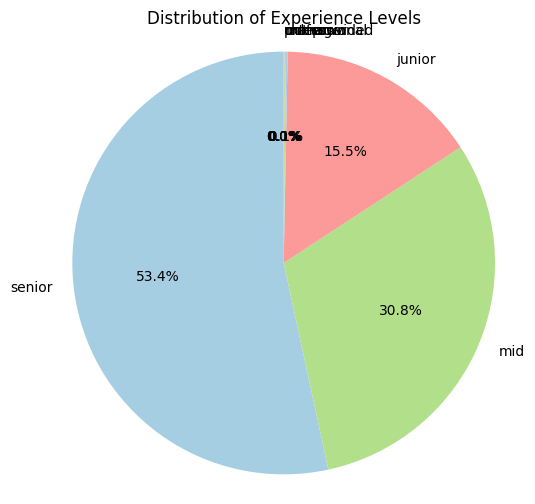

In [69]:
# Plot how many juniors, mid, seniors
import matplotlib.pyplot as plt

# Load the cleaned dataset
df_cleaned = pd.read_csv('./cleaned_resumes.csv')

# Count the experience levels
level_counts = df_cleaned['experience_level'].value_counts()

# Create pie chart
plt.figure(figsize=(6, 6))
plt.pie(level_counts, labels=level_counts.index, autopct='%1.1f%%', startangle=90, colors=['#a6cee3','#b2df8a','#fb9a99'])
plt.title('Distribution of Experience Levels')
plt.axis('equal')  # Equal aspect ratio ensures pie is drawn as a circle.
plt.show()
